# Import 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import zeta
from scipy import integrate, interpolate
import pandas as pd
import time
import pickle
from scipy.interpolate import interp1d, RegularGridInterpolator
import equations_and_constants as ec
from scipy.integrate import quad
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint


In [2]:
plt.rcParams.update({'font.size': 22})

# Constants

In [4]:
# Unit conversions
hbar = 6.582*10**-16 #eV s
MeVtoHz = 10**6/hbar
HztoMeV = hbar/10**6
kb =  1.380649*10**-23 #J/K 
charge = 1.602176634*10**-19 #C
MeVtoJ = 10**6*charge
JtoMeV = 10**-6/charge
KtoMeV = kb*JtoMeV
eVtoMeV = 10**-6
c = 2.9979*10**8 #m/s
MeVtoinversecm = 10**6/(hbar*c*100)

# Masses, all in MeV
# Leptons
m_e, m_mu, m_tau = 0.510,105.7,1776.9
# Quarks
m_u, m_d, m_s, m_c, m_b, m_t = 2.3,4.8,95,1290,4180,173500
# Gauge bosons
m_W, m_Z, m_H = 80400,91200,125090
#Baryons
m_p, m_n = 938,939
# Mesons
m_pi0, m_pipm, m_K0, m_Kpm, m_eta, m_etaprime, m_rhopm, m_rho0, m_omega = 134.9766,139.570,497.614,493.678,647.862,957.78,775.11,775.26,782.65
# all masses
masses = np.sort([m_e, m_mu, m_tau, m_u, m_d, m_s, m_c, m_b, m_t, m_W, m_Z, m_H, m_pi0, m_pipm, m_K0, m_Kpm, m_eta, m_etaprime, m_rhopm, m_rho0, m_omega])
discontinuity_masses = np.sort([m_mu, m_tau, m_c, m_b, m_t, m_W, m_Z, m_H, m_pi0, m_pipm])

# Other fundamental constants, all in MeV unless otherwise noted
Gf = 1.166 * 10**-5 *10**-6 #MeV**-2
grav = (1.22*10**22)**-2 #MeV**-2 
thetaW = np.arcsin(np.sqrt(0.2229))
fine_structure = 7.297352*10**-3
eta_B = 6*10**-10 #baryon asymmetry
f_pi = 131 # for pion channel decay
# QCD Transition temperature and width
T_qcd = 170 
w_qcd = 10
h=0.7 # hubble factor
omega_dm_hsq = 0.120 #omega_m*h^2, planck 2018, error is 0.001
H100 =  100*3.24*10**-20*HztoMeV
Tcmb = 2.725*KtoMeV
TcmbtoTcnub = (4./11)**(1./3)

# Calculate T_DS

In [3]:
def compute_dT_DS_da(a, T_SM, T_DS, ms1, ms2, theta, flavor, merle_simplification=False, antineutrino=False):
    return compute_dT_DS_dt(T_SM, T_DS, ms1, ms2, theta, flavor, merle_simplification, antineutrino)/(a*ec.Hubble_rate(T_SM))

def compute_dT_DS_dt(T_SM, T_DS, ms1, ms2, theta, flavor, merle_simplification=False, antineutrino=False):
    drho_dT = 2*(ec.compute_drho_dT(T_DS, ms1, 1) + ec.compute_drho_dT(T_DS, ms2, 1))
    drho_inj_dt = compute_drho_injected_dt(T_SM, ms1, theta, flavor, merle_simplification, antineutrino)
    rho = compute_rho_DS(T_DS, ms1, ms2)
    pressure = compute_pressure_DS(T_DS, ms1, ms2)
    return (-3*ec.Hubble_rate(T_SM)*(rho + pressure) + drho_inj_dt)/drho_dT

def compute_rho_DS(T_DS, ms1, ms2):
    return 2*ec.compute_energy_density(T_DS, ms1, 1) + 2*ec.compute_energy_density(T_DS, ms2, 1)

def compute_pressure_DS(T_DS, ms1, ms2):
    return 2*ec.compute_pressure(T_DS, ms1, 1) + 2*ec.compute_pressure(T_DS, ms2, 1)

def compute_drho_injected_dt(T_SM, ms, theta, flavor, merle_simplification=False, antineutrino=False):
    y = float(ms)/T_SM
    def integrand(x):
        return ec.SID_rate(x*T_SM, T_SM, theta, ms, flavor, antineutrino, 
                        merle_simplification)*x**2*np.sqrt(x**2 + y**2)/(np.exp(np.sqrt(x**2 + y**2)) + 1)
    result, err = quad(integrand, 0.1, 20)
#    return T_SM**4*result/(2*np.pi**2)
    return 0

def compute_dT_SM_da(T_SM, a):
    return ec.dTemperature_dtime(T_SM)/(a*ec.Hubble_rate(T_SM))

def compute_T_DS(a_min, a_max, T_SM, T_DS, ms1, ms2, theta, flavor, merle_simplification=False, antineutrino=False):
    result, err = quad(compute_dT_DS_da, a_min, a_max, args=(T_SM,T_DS,ms1,ms2,theta,flavor,merle_simplification,antineutrino))
    return result, err

def compute_T_SM(T_start, a_start, a_fin, num_a, logspace=True):
    if logspace:
        a_domain = np.logspace(np.log10(a_start), np.log10(a_fin), num_a)
    else:
        a_domain = np.linspace(a_start, a_fin, num_a)
    T_vals = odeint(compute_dT_SM_da, T_start, a_domain)
    return T_vals.flatten(), a_domain

In [ ]:
(105./85.)

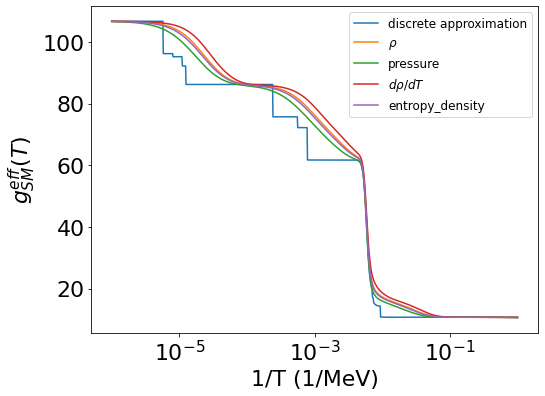

In [4]:
Tdomain = np.logspace(6, 0, 1000)
#save_thermodynamic_quantities(Tdomain, 'for_boltzmann_calc/SM_thermodynamic_quantities.pkl')

dofs = [ec.compute_SM_relativistic_dof_approx(T) for T in Tdomain]
plt.figure(figsize=(8,6))
plt.ylabel(r"$g^{eff}_{SM}(T)$")
plt.xlabel("1/T (1/MeV)")
plt.semilogx(1/Tdomain, dofs, label='discrete approximation')
plt.semilogx(1/Tdomain, ec.SM_energy_density(Tdomain)/(Tdomain**4*np.pi**2/30), label=r'$\rho$')
plt.semilogx(1/Tdomain, ec.SM_pressure(Tdomain)/(Tdomain**4*np.pi**2/90), label='pressure')
plt.semilogx(1/Tdomain, ec.SM_drho_dT(Tdomain)/(4*(np.pi**2/30)*Tdomain**3), label=r'$d\rho /dT$')
plt.semilogx(1/Tdomain, ec.SM_entropy_density(Tdomain)/((4/3.)*(np.pi**2/30)*Tdomain**3), label='entropy_density')
plt.legend(fontsize=12)
plt.show()    

In [6]:
T_start = 10**6
a_min=1
a_max=10**6
num_a = 10**6
T_vals, a_domain = compute_T_SM(T_start, a_min, a_max, num_a, logspace=True)

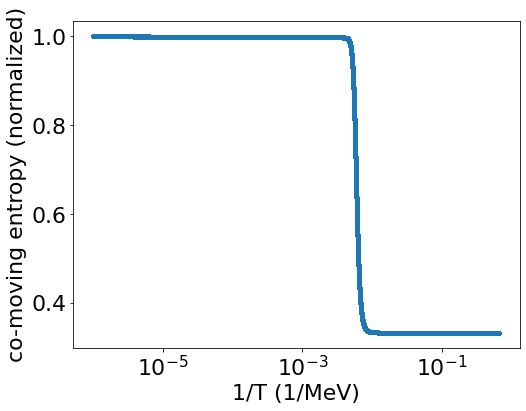

In [8]:
g_eff_ent = ec.SM_entropy_density(T_vals)/((4/3.)*(np.pi**2/30)*T_vals**3)
ent_start = g_eff_ent[0]*(T_start*a_min)**3
entropy = g_eff_ent*(T_vals*a_domain)**3/ent_start
plt.figure(figsize=(8,6))
plt.semilogx(1/T_vals, entropy, '.')
plt.xlabel("1/T (1/MeV)")
plt.ylabel(r"co-moving entropy (normalized)")
plt.show()

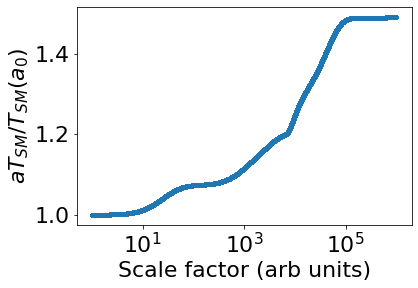

In [50]:
T_start = 10**6
a_min=1
a_max=10**6
num_a = 10**6
T_vals, a_domain = compute_T_SM(T_start, a_min, a_max, num_a, logspace=True)
plt.semilogx(a_domain, T_vals*a_domain/T_start, '.')
plt.xlabel("Scale factor (arb units)")
plt.ylabel(r"$a T_{SM}/T_{SM}(a_0)$")
plt.show()

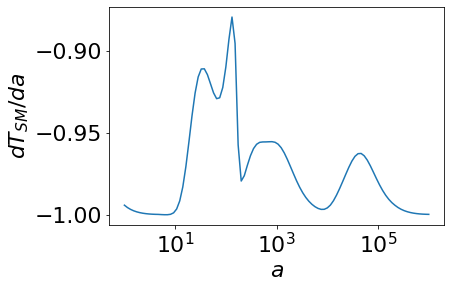

In [17]:
Tdomain = np.logspace(0, 6, 100)
dTSM_da = [compute_dT_SM_da(temp, temp) for temp in Tdomain]
plt.semilogx(Tdomain, dTSM_da)
plt.ylabel(r"$dT_{SM}/da$")
plt.xlabel(r"$a$")
plt.show()

# Numerical Boltzmann Calculation

### Check the integrand

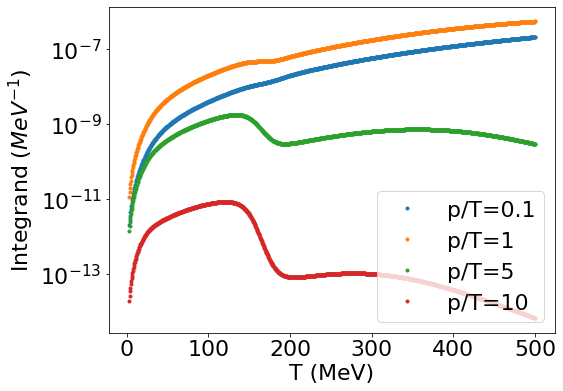

In [4]:
Ti=500
Tf=3
Tprimes = np.linspace(Tf, Ti, 1000)
theta=0.5*np.sqrt(10**-10)
ms=10**-1
antineutrino=False
merle_simplification=True
flavor='electron'

plt.figure(figsize=(8,6))
for poverT in [0.1, 1, 5, 10]:
    integrands = [ec.boltzmann_integrand(Tp, poverT*Tf, Tf, theta, ms, flavor, antineutrino, merle_simplification) for Tp in Tprimes]
    plt.semilogy(Tprimes, integrands, '.', label="p/T={}".format(poverT))
plt.ylabel(r"Integrand ($MeV^{-1}$)")
plt.xlabel("T (MeV)")
plt.legend()
plt.show()

### Solve

/home/jakespisak/Fuller/sterile_sterile_interactions/equations_and_constants.py:503: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, err = quad(boltzmann_integrand, limits[i], limits[i+1], args=(p, Tf, theta, ms, flavor, antineutrino, merle_simplification))
/home/jakespisak/Fuller/sterile_sterile_interactions/equations_and_constants.py:503: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, err = quad(boltzmann_integrand, limits[i], limits[i+1], args=(

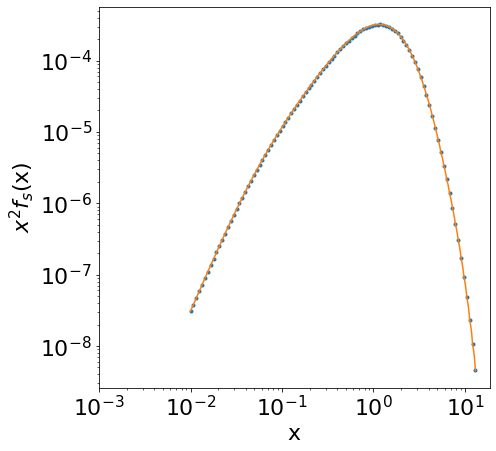

fint=0.0008826175819282756, err=2.1363123995504774e-09


In [5]:
theta=0.5*np.sqrt(10**-10)
ms=10**-1
antineutrino=False
merle_simplification=True
flavor='electron'
Ti = 2000
Tf = 1.

poverT_min, poverT_max = 0.01, 13
poverTs = np.logspace(np.log10(poverT_min), np.log10(poverT_max), 100)
f = []
for p in poverTs*Tf:
    result, err = ec.boltzmann_solve(p, Ti, Tf, theta, ms, flavor, ec.discontinuity_masses, antineutrino, merle_simplification)
    f.append(-1*result)

# Interpolate and integrate the results
f_integrand = interp1d(poverTs, f, kind='linear')
plt.figure(figsize=(7,7))
plt.loglog(poverTs, np.array(f)*poverTs**2, '.')
smoothed_poverTs = np.logspace(np.log10(poverT_min), np.log10(poverT_max), 1000)
plt.loglog(smoothed_poverTs, f_integrand(smoothed_poverTs)*smoothed_poverTs**2)
plt.xticks(np.logspace(-2, 1, 5))
plt.ylabel(r"$x^2 f_s$(x)")
plt.xlabel("x")
plt.show()

fint, err = quad(f_integrand, poverT_min, poverT_max)
print("fint={}, err={}".format(fint, err))

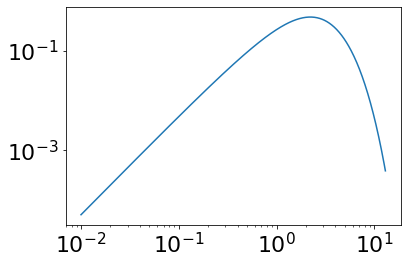

In [7]:
plt.loglog(smoothed_poverTs, ec.fermi_dirac(smoothed_poverTs, 1)*smoothed_poverTs**2)

In [13]:
# Convert to omega_m
T0 = Tcmb*(ec.compute_SM_relativistic_dof(Tcmb)/ec.compute_SM_relativistic_dof(Tf))**(1/3.0)
print("Multiplying by two to include antineutrinos")
ndens = ec.fint_to_n(2*fint, T0)
print("Number of neutrinos per cm^-3 {}".format(ndens*MeVtoinversecm**3))

m_relic=ms
print("omega h^2 ={} for m_relic={} keV".format(ec.rho_to_omegahsq(m_relic*ndens), 10**3*m_relic))

Multiplying by two to include antineutrinos
Number of neutrinos per cm^-3 8.715982454994573e-05
omega h^2 =8.287710551249819e-08 for m_relic=0.01 keV


### Compare to fortepiano results

In [ ]:
from python.fortepianoOutput import FortEPiaNORun

# Model parameters
params={
"m4": 1.3*10**-6, #MeV
"theta": 0.01
}

# Analytic results
T = np.logspace(0, 3, 400)
sid = ec.SID_rate(ec.avg_p(T), T, params["theta"], params["m4"], 'electron')

#thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**3, 1, params["theta"], params["m4"], 'electron', antineutrino=False, num_T=1000)

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate', c='b')
ax1.loglog(1/T, sid*MeVtoHz, label=r"$\Gamma_{SID}$(p=3kT, T)", c='b', ls='--')
#ax1.axvline(1/Tmax(params["m4"]), c='r', ls='--', label="Production peak")
# if thermalized:
#     ax1.axvline(1/T_thermal, c='r', ls='--', label=r"$\Gamma_{SID} = H$")
ax1.set_ylabel("Rate (Hz)")
ax1.set_xlabel("1/T (1/MeV)")
ax1.legend(loc=2)
ax1.yaxis.label.set_color('b')
ax1.tick_params(axis='y', colors='b')

# Fortepiano results
yref =7 # p=2.86kT according to fd.dat
fp_run = FortEPiaNORun("output/sterile_Garrazio_benchmark/", nnu=4, deltas=False,plots=False)
flavs = ['e', 'mu', 'tau', 's1']
labels = [r"$\rho_e$(p=3kT)", r"$\rho_\mu$(p=3kT)", r"$\rho_\tau$(p=3kT)", r"$\rho_s$(p=3kT)"]
lines = ["dotted", "dotted", "dotted", "dashdot"]
for i, flav, label, ls in zip(range(4), flavs, labels, lines):
    if flav not in ['mu', 'tau']:
        x, rho_ij = FortEPiaNORun.interpolateRhoIJ(fp_run, i, i, yref, mass=False)
        rho_ij = [r for _, r in sorted(zip(x, rho_ij))]
        x = sorted(x)
        ax2.semilogx(x, rho_ij, c='r', ls=ls, label=label)
ax2.set_ylabel(r"Fortepiano $\rho$")            
ax2.legend(loc=4)
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r')
plt.xlim(10**-3, 1)
plt.title(r"$m_s={} MeV, \theta={}$".format(params['m4'], params['theta']))
plt.show()

# Parameter Scan

In [9]:
ms_log_min, ms_log_max = -5, -2
ms_domain = np.logspace(ms_log_min, ms_log_max, 15)
sinsq_theta_log_min, sinsq_theta_log_max = -12, -6
sinsq_theta_domain = np.logspace(sinsq_theta_log_min, sinsq_theta_log_max, 15)
Ti = 1000
Tf = 1/35.

start = time.time()
omegahsq_results = []
for sinsq_theta in sinsq_theta_domain:
    print("sinsq_theta={}, time={}".format(ms, sinsq_theta, time.time()-start))
    omegahsq_results.append([])
    for ms in ms_domain:
        f, poverTs, f_xsq_integrand, omegahsq = ec.compute_f_and_omegahsq(ms, 0.5*np.arcsin(np.sqrt(sinsq_theta)), True, 'electron', 
                                                                       Ti, Tf, poverT_min=0.01, poverT_max=15, antineutrino=False)
        omegahsq_results[-1].append(omegahsq)

sinsq_theta=0.00021544346900318823, time=1e-12
sinsq_theta=0.01, time=2.6826957952797272e-12
sinsq_theta=0.01, time=7.1968567300115285e-12
sinsq_theta=0.01, time=1.9306977288832457e-11
sinsq_theta=0.01, time=5.179474679231202e-11
sinsq_theta=0.01, time=1.389495494373136e-10
sinsq_theta=0.01, time=3.727593720314938e-10


/home/jakespisak/Fuller/sterile_sterile_interactions/equations_and_constants.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fint, err = quad(f_xsq_integrand, poverT_min, poverT_max)


sinsq_theta=0.01, time=1e-09
sinsq_theta=0.01, time=2.6826957952797275e-09
sinsq_theta=0.01, time=7.1968567300115284e-09


/home/jakespisak/Fuller/sterile_sterile_interactions/equations_and_constants.py:370: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, err = quad(integrand, limits[i], limits[i+1], args=(p, Tf, theta, ms, flavor, antineutrino, merle_simplification))


sinsq_theta=0.01, time=1.9306977288832496e-08


/home/jakespisak/Fuller/sterile_sterile_interactions/equations_and_constants.py:370: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, err = quad(integrand, limits[i], limits[i+1], args=(p, Tf, theta, ms, flavor, antineutrino, merle_simplification))


sinsq_theta=0.01, time=5.1794746792312124e-08
sinsq_theta=0.01, time=1.389495494373136e-07
sinsq_theta=0.01, time=3.727593720314938e-07
sinsq_theta=0.01, time=1e-06


In [24]:
ms_domain

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03])

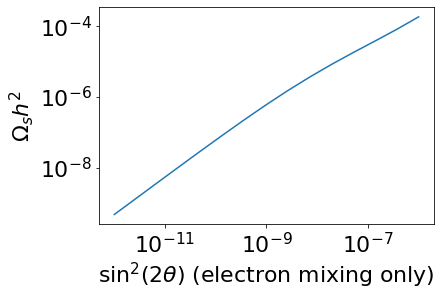

In [10]:
plt.loglog(sinsq_theta_domain, omegahsq_results[0])
plt.ylabel(r"$\Omega_s h^2$")
plt.xlabel(r"$\sin^2(2 \theta)$ (electron mixing only)")
plt.show()

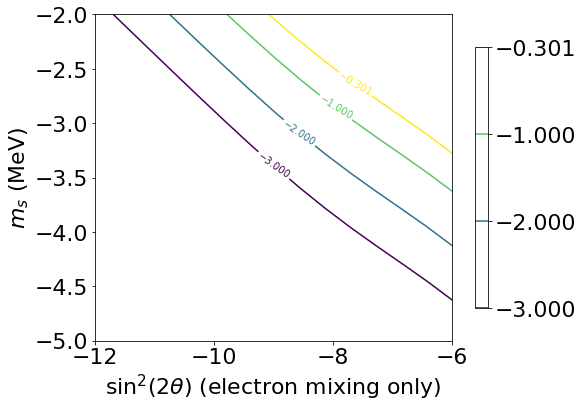

In [14]:
X, Y = np.meshgrid(np.log10(sinsq_theta_domain), np.log10(ms_domain))

plt.figure(figsize=(8,6))
CS = plt.contour(X, Y, np.log10(omegahsq_results), [-3, -2, -1, np.log10(0.5)])
plt.clabel(CS, inline=True, fontsize=10)
plt.ylabel(r"$m_s$ (MeV)")
plt.xlabel(r"$\sin^2(2 \theta)$ (electron mixing only)")
CB = plt.colorbar(CS, shrink=0.8)
plt.show()

In [30]:
np.log10(omegahsq_results)

array([[-6.32143308, -5.32142601, -4.32141804, -3.32142241],
       [-5.2655645 , -4.26554843, -3.26557251, -2.26557712],
       [-4.2218018 , -3.22173916, -2.22175198, -1.22175516],
       [-3.22057563, -2.22057577, -1.2205781 , -0.2205814 ],
       [-2.319361  , -1.31936176, -0.31936644,  0.68063235]])

# Nu5 from SID to Nu4: approximate solution

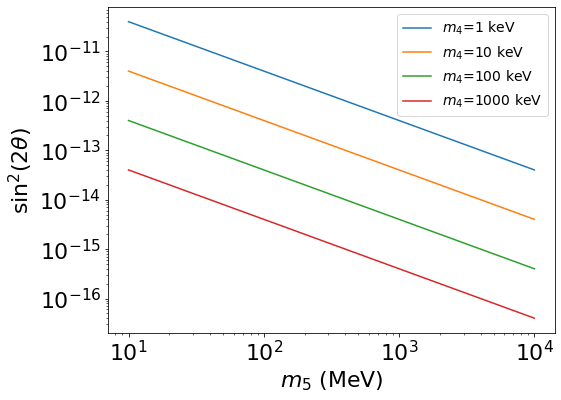

In [17]:
def sinsq2theta_from_dw54(m_4, m_5):
    """m_4, m_5 in MeV"""
    return (m_5/m_4)*(omega_dm_hsq/0.3)*10**-10*(m_5/0.1)**-2


m_4_array = np.logspace(-3, 0, 4)
m_5 = np.logspace(1, 4, 100)
plt.figure(figsize=(8,6))
for m_4 in m_4_array:
    plt.loglog(m_5, sinsq2theta_from_dw54(m_4, m_5), label=r"$m_4$={} keV".format(int(m_4*10**3)))
plt.legend(fontsize=14)
plt.ylabel(r"$\sin^2(2\theta)$")
plt.xlabel(r"$m_5$ (MeV)")
plt.show()

# Compute and save the lepton integral results (don't need to run every time)

In [ ]:
def lepton_integral(n, x):
    """Occupation number integrals"""
    integrand = lambda y, x: y**n/(np.exp(np.sqrt(x**2 + y**2))-1)
    # Need to distinguish between scalars and arrays
    if np.isscalar(x):
        result, _ = integrate.quad(integrand, 0, 100, args=(x))
    else:
        result = [integrate.quad(integrand, 0, 100, args=(x_val))[0] for x_val in x]
    return result

# Compute the integral
data_dic = {}
for n in [2,3]:
    x_domain = np.logspace(-2, 2, 1000)
    data = lepton_integral(n, x_domain)
    x_domain_extended = np.concatenate(([0], x_domain, [np.inf]))
    data_extended = np.concatenate(([data[0]], data, [0]))
    data_dic[n] = {
        "x":x_domain_extended,
        "value":data_extended
    }
with open("/home/jakespisak/Fuller/sterile_sterile_interactions/for_boltzmann_calc/lepton_integrals.pkl", 'wb') as f:
    pickle.dump(data_dic, f)

# Check individual equations

## SM Thermodynamics

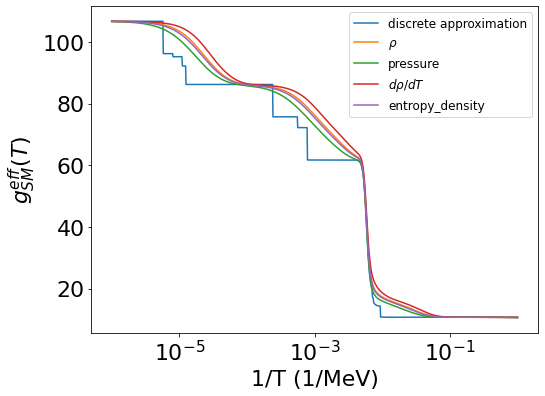

In [48]:
Tdomain = np.logspace(6, 0, 1000)
#save_thermodynamic_quantities(Tdomain, 'for_boltzmann_calc/SM_thermodynamic_quantities.pkl')

dofs = [ec.compute_SM_relativistic_dof_approx(T) for T in Tdomain]
plt.figure(figsize=(8,6))
plt.ylabel(r"$g^{eff}_{SM}(T)$")
plt.xlabel("1/T (1/MeV)")
plt.semilogx(1/Tdomain, dofs, label='discrete approximation')
plt.semilogx(1/Tdomain, ec.SM_energy_density(Tdomain)/(Tdomain**4*np.pi**2/30), label=r'$\rho$')
plt.semilogx(1/Tdomain, ec.SM_pressure(Tdomain)/(Tdomain**4*np.pi**2/90), label='pressure')
plt.semilogx(1/Tdomain, ec.SM_drho_dT(Tdomain)/(4*(np.pi**2/30)*Tdomain**3), label=r'$d\rho /dT$')
plt.semilogx(1/Tdomain, ec.SM_entropy_density(Tdomain)/((4/3.)*(np.pi**2/30)*Tdomain**3), label='entropy_density')
plt.legend(fontsize=12)
plt.show()    

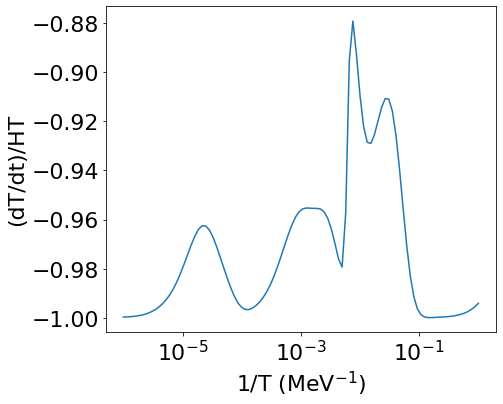

In [8]:
Tdomain = np.logspace(6, 0, 100)
plt.figure(figsize=(7,6))
plt.semilogx(1/Tdomain, -1*ec.dTemperature_dtime(Tdomain)/(ec.Hubble_rate(Tdomain)*Tdomain))
plt.xlabel(r"1/T (MeV$^{-1}$)")
plt.ylabel(r"(dT/dt)/HT")
plt.show()

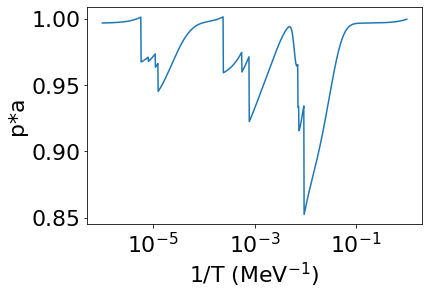

In [10]:
p=1
Tf=1
Tprime = np.logspace(6, 0, 1000)

dofs = [ec.compute_SM_relativistic_dof_approx(T) for T in Tprime]
momentum1 = p*(Tprime/Tf)*(dofs/ec.compute_SM_relativistic_dof_approx(Tf))**(1/3.0)
momentum2 = p*(ec.SM_entropy_density(Tprime)/ec.SM_entropy_density(Tf))**(1./3)
plt.semilogx(1/Tprime, momentum1/momentum2)
plt.ylabel("pa")
plt.xlabel(r"1/T (MeV$^{-1}$)")
plt.show()

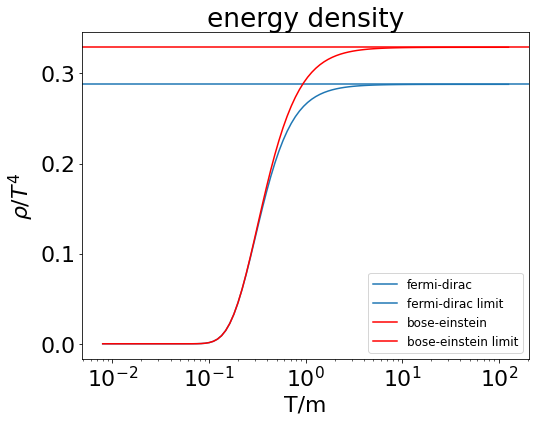

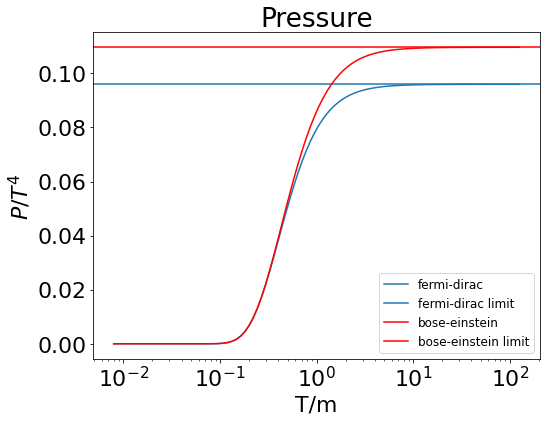

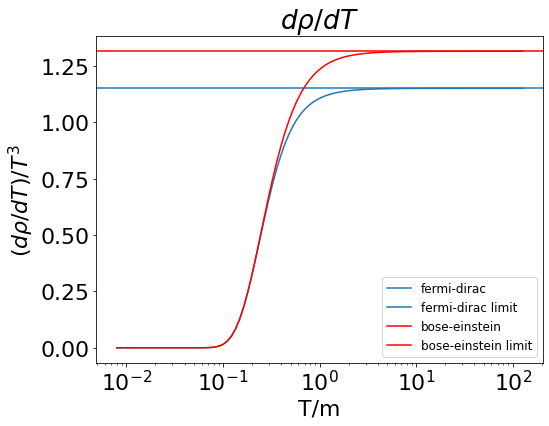

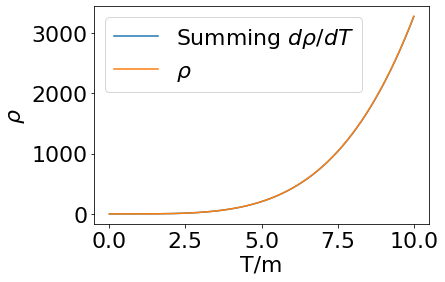

rho=3285.5459656355692, summing drhodT check=3279.0484482696447


In [8]:
m = 10**-0
temps = m*np.logspace(-2.1, 2.1, 100)

plt.figure(figsize=(8,6))
plt.title("energy density")
rho = [ec.compute_energy_density(T, m, 1)/T**4 for T in temps]    
plt.semilogx(temps/m, rho, label="fermi-dirac")
plt.axhline((7/8.)*np.pi**2/30, label="fermi-dirac limit")

rho = [ec.compute_energy_density(T, m, -1)/T**4 for T in temps]
plt.semilogx(temps/m, rho, c='r', label="bose-einstein")
plt.axhline(np.pi**2/30, c='r', label="bose-einstein limit")
plt.legend(fontsize=12)
plt.xlabel("T/m")
plt.ylabel(r"$\rho/T^4$")
plt.show()

plt.figure(figsize=(8,6))
plt.title("Pressure")
pres = [ec.compute_pressure(T, m, 1)/T**4 for T in temps]    
plt.semilogx(temps/m, pres, label="fermi-dirac")
plt.axhline((1/3.)*(7/8.)*np.pi**2/30, label="fermi-dirac limit")

pres = [ec.compute_pressure(T, m, -1)/T**4 for T in temps]    
plt.semilogx(temps/m, pres, c='r', label="bose-einstein")
plt.axhline((1/3.)*np.pi**2/30, c='r', label="bose-einstein limit")
plt.legend(fontsize=12)
plt.xlabel("T/m")
plt.ylabel(r"$P/T^4$")
plt.show()

plt.figure(figsize=(8,6))
plt.title(r"$d \rho/dT$")
drdT = [ec.compute_drho_dT(T, m, 1)/T**3 for T in temps]    
plt.semilogx(temps/m, drdT, label="fermi-dirac")
plt.axhline(4*(7/8.)*np.pi**2/30, label="fermi-dirac limit")

drdT = [ec.compute_drho_dT(T, m, -1)/T**3 for T in temps]    
plt.semilogx(temps/m, drdT, c='r', label="bose-einstein")
plt.axhline(4*np.pi**2/30, c='r', label="bose-einstein limit")
plt.legend(fontsize=12)
plt.xlabel("T/m")
plt.ylabel(r"$\left( d \rho/dT \right)/T^3$")
plt.show()

# Check drhodT equation
Toverm_max = 10
increment = 0.01
temps = m*np.arange(0.01, Toverm_max, increment)
drdT = [ec.compute_drho_dT(T, m, -1) for T in temps]
drdT_rhos = [m*increment*np.sum(drdT[:i]) for i in range(len(drdT))]
rhos = [ec.compute_energy_density(T, m, -1) for T in temps]
plt.plot(temps/m, drdT_rhos, label=r"Summing $d\rho/dT$")
plt.plot(temps/m, rhos, label=r'$\rho$')
plt.xlabel("T/m")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()
print("rho={}, summing drhodT check={}".format(ec.compute_energy_density(Toverm_max*m, m, -1), m*increment*np.sum(drdT)))

## Conversion to Omega_m

In [6]:
# CMB number sanity check: should be 411 photons per cm^-3 and Omega_cmb = 5.38*10*-5
# https://pdg.lbl.gov/2020/reviews/rpp2020-rev-cosmic-microwave-background.pdf
fint = 2*zeta(3)
gphoton=2
ndens_cmb = ec.fint_to_n(2*fint, Tcmb)
print("Number of photons per cm^-3 {}".format(ndens_cmb*MeVtoinversecm**3))
rho_cmb = gphoton*Tcmb**4*(np.pi**4/15.)/(2*np.pi**2)
print("omega_cmb = {}".format(ec.rho_to_omegahsq(rho_cmb)/h**2))

Number of photons per cm^-3 410.53331255544435
omega_cmb = 5.053161234954483e-05


In [7]:
# CnuB sanity check: see equation 25.2 here: https://pdg.lbl.gov/2019/reviews/rpp2019-rev-neutrinos-in-cosmology.pdf

g_nu = 2 #per flavor
fint = 1.5*zeta(3)
Tnu = Tcmb*(4./11)**(1/3.)
ndens_nu = ec.fint_to_n(g_nu*fint, Tnu)
print("Number of neutrinos per flavor per cm^-3 {}".format(ndens_nu*MeVtoinversecm**3))

sum_mnu = 93*eVtoMeV
print("omega_cnub h^2 for sum_mnu = 93eV {}".format(ec.rho_to_omegahsq(sum_mnu*ndens_nu)))

Number of neutrinos per flavor per cm^-3 111.9636306969394
omega_cnub h^2 for sum_mnu = 93eV 0.9900979224033691


## Relativistic DOFs

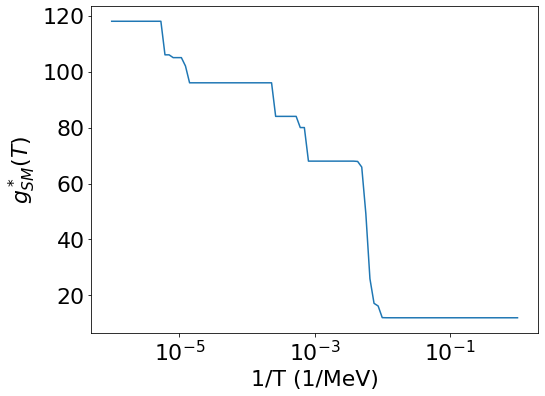

In [102]:
Tdom = np.logspace(6, 0, 100)
dofs = [ec.compute_SM_relativistic_dof(T) for T in Tdom]
plt.figure(figsize=(8,6))
plt.ylabel(r"$g^*_{SM}(T)$")
plt.xlabel("1/T (1/MeV)")
plt.semilogx(1/Tdom,dofs)
plt.show()

## Neutrino thermal scattering coefficients

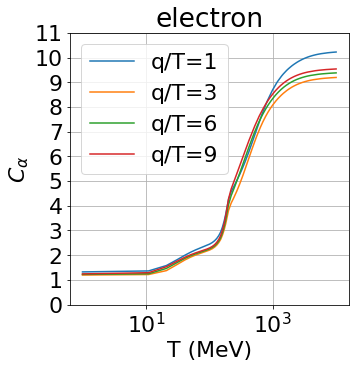

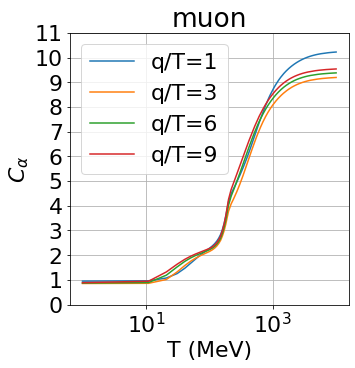

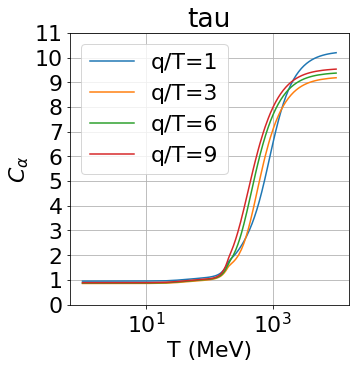

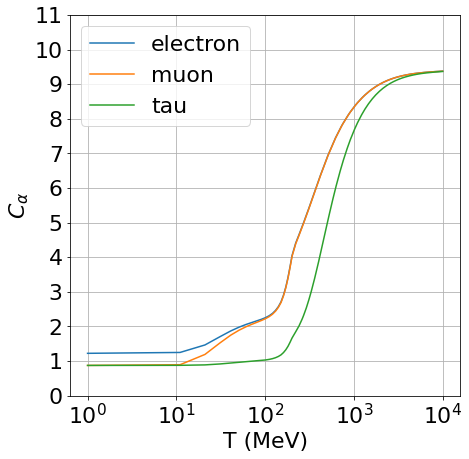

In [6]:
# Compare to figure 1 and 2 here: http://www.laine.itp.unibe.ch/neutrino-rate/imSigma.pdf

T_domain = np.linspace(1, 10**4, 10**3)
for flavor in ['electron', 'muon', 'tau']:
    plt.figure(figsize=(5,5))
    for qoverT in [1, 3, 6, 9]:
        plt.semilogx(T_domain, ec.scattering_coeffs_1Mev_to_5_GeV(T_domain, qoverT*T_domain, flavor), label='q/T={}'.format(qoverT))
    plt.ylabel(r"$C_\alpha$")
    plt.xlabel("T (MeV)")
    plt.title(flavor)
    #plt.xticks(np.logspace(min(np.log10(T_domain)), max(np.log10(T_domain)), 5))
    plt.yticks(np.arange(0, 12, 1))
    plt.grid()
    plt.legend()
    plt.show()

# Compare to figure 10 in Dodelson-Widrow production of sterile neutrino DM with non-trivial initial abundance

plt.figure(figsize=(7,7))
qoverT = 6
for flavor in ['electron', 'muon', 'tau']:
    plt.semilogx(T_domain, ec.scattering_coeffs_1Mev_to_5_GeV(T_domain, qoverT*T_domain, flavor), label=flavor)
plt.ylabel(r"$C_\alpha$")
plt.xlabel("T (MeV)")
plt.xticks(10**np.arange(0, 5, 1))
plt.yticks(np.arange(0, 12, 1))
plt.grid()
plt.legend()
plt.show()

## Active neutrino scattering rate: T>5 GeV

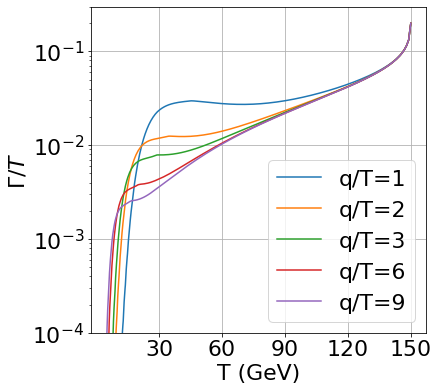

In [32]:
# Compare to fig. 6 in https://arxiv.org/pdf/1605.07720.pdf
T_domain = np.linspace(5*10**3, 150*10**3, 1000)
flavor='electron'

plt.figure(figsize=(6,6))
for qoverT in [1, 2, 3, 6, 9]:
    plt.semilogy(T_domain*10**-3, ec.active_scattering_rate(qoverT*T_domain, T_domain, flavor)/T_domain, label='q/T={}'.format(qoverT))
plt.ylabel(r"$\Gamma/T$")
plt.xlabel("T (GeV)")
plt.xticks(30*np.arange(1, 6, 1))
#plt.yticks(np.arange(0, 12, 1))
plt.ylim(10**-4, 3*10**-1)
plt.grid()
plt.legend()
plt.show()

## Combined Active Neutrino Scattering Rate

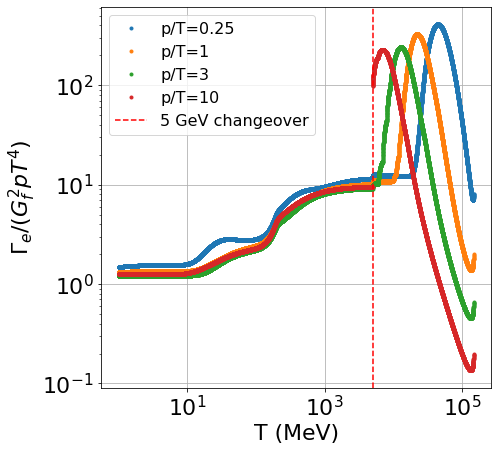

In [42]:
# Compare to fig. 6 in https://arxiv.org/pdf/1605.07720.pdf
T_domain = np.logspace(0, np.log10(149*10**3), 10**4)
#T_domain = np.logspace(3, 3.7, 10**3)
flavor='electron'

plt.figure(figsize=(7,7))
for poverT in [0.25, 1, 3, 10]:
    p_domain = poverT*T_domain
    plt.loglog(T_domain, ec.active_scattering_rate(p_domain, T_domain, flavor)/(Gf**2*p_domain*T_domain**4),  '.', label='p/T={}'.format(poverT))
plt.ylabel(r"$\Gamma_e / (G_f^2 p T^4)$")
plt.xlabel("T (MeV)")
plt.axvline(5*10**3, c='r', ls='--', label="5 GeV changeover")
#plt.xticks(np.logspace(0, 5, 6))
plt.grid()
plt.legend(fontsize=16)
plt.show()

## h(T,p)

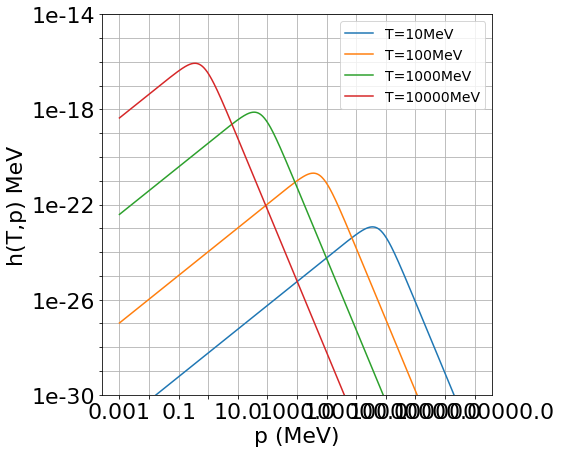

In [3]:
theta=np.sqrt(7*10**-11)
ms=0.007
flavor='electron'
antineutrino=False
momenta = np.logspace(-3, 9, 1000)

plt.figure(figsize=(7,7))
for T in [10**1, 10**2, 10**3, 10**4]:
    plt.loglog(momenta, ec.h(momenta, T, theta, ms, flavor, antineutrino, merle_simplification=True), label="T={}MeV".format(T))
plt.legend(fontsize=14)
plt.ylabel("h(T,p) MeV")
plt.xlabel("p (MeV)")
yticks=np.logspace(-14, -30, 17)
plt.yticks(ticks=yticks, labels=[str(ytick) if i % 4 == 0 else '' for i, ytick in enumerate(yticks)])
xticks=np.logspace(-3, 9, 13)
plt.xticks(ticks=xticks, labels=[str(xtick) if i % 2 == 0 else '' for i, xtick in enumerate(xticks)])
plt.grid()
plt.ylim(10**-30, 10**-14)
plt.show()

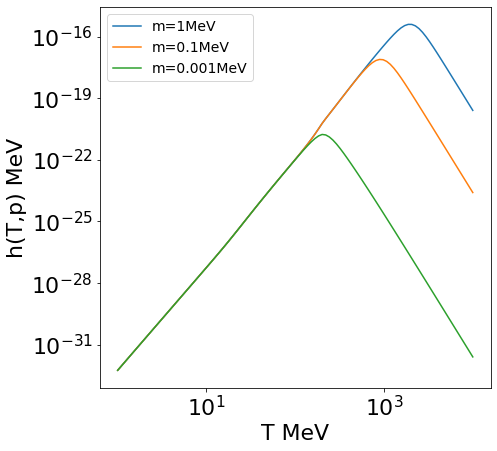

In [16]:
theta=np.sqrt(7*10**-11)
ms=0.07
flavor='electron'
antineutrino=False

plt.figure(figsize=(7,7))
poverT = 1
Tdomain = np.logspace(4, 0, 100)
    for T in Tdomain:
        hresults.append(ec.h(poverT*T, T, theta, ms, flavor, antineutrino, merle_simplification=True))
    plt.loglog(Tdomain, hresults, label="m={}MeV".format(ms))
plt.legend(fontsize=14)
plt.ylabel("h(T,p) MeV")
plt.xlabel("T MeV")
plt.show()

## Check DW SID rate vs the more detailed production rate

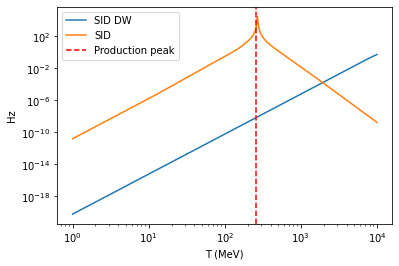

In [7]:
params={
"m4": 7*10**-3, #MeV
"theta": 0.5*np.sqrt(7*10**-11),
}

T = np.logspace(0, 4, 500)

sid_DW = ec.SID_rate_DW(T, params["theta"], params["m4"])
sid = ec.SID_rate(T, params["theta"], params["m4"], 'electron', antineutrino=False)

plt.loglog(T, sid_DW*MeVtoHz, label='SID DW')
plt.loglog(T, sid*MeVtoHz, label="SID")
plt.axvline(ec.Tmax(params["m4"]), c='r', ls='--', label="Production peak")
plt.ylabel("Hz")
plt.xlabel("T (MeV)")
plt.legend()
plt.show()

## Generic Production Rate

In [8]:
def SID_rate_integrated(T, theta, m5, flavor, pmin=0.01,pmax=10):
    if np.isscalar(T):
        integrand = lambda p: ec.SID_rate(p, T, theta, m5, flavor)*p**2/(np.exp(p/T)+1)
        result, err = quad(integrand, pmin*T, pmax*T)
        return result/(1.5*T**3*zeta(3))
    else:
        rates = []
        for Ti in T:
            integrand = lambda p: ec.SID_rate(p, Ti, theta, m5, flavor)*p**2/(np.exp(p/Ti)+1)
            result, err = quad(integrand, pmin*Ti, pmax*Ti)
            rates.append(result/(1.5*Ti**3*zeta(3)))
        return np.array(rates)
            

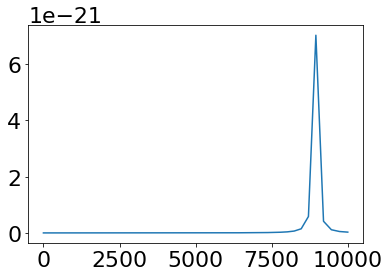

In [36]:
pdom = np.logspace(-2, 4, 500)
T=1
plt.plot(pdom, ec.SID_rate(pdom, T, params["theta"], params["m5"], 'electron'))
plt.show()

In [41]:
params={
"m5": 10**2, #MeV
"theta": 10**-5,
}

T = np.logspace(1.95, 5, 100)

#sid = ec.SID_rate(ec.avg_p(T), T, params["theta"], params["m5"], 'electron')
sid_integrated = SID_rate_integrated(T, params["theta"], params["m5"], 'electron', pmin=0.1, pmax=10**3)

plt.figure(figsize=(8,6))
plt.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate')
#plt.loglog(1/T, sid*MeVtoHz, label="SID")
plt.loglog(1/T, sid_integrated*MeVtoHz, label=r"$\Gamma_{SID}$")

thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**5, 1, params["theta"], params["m5"], 'electron', antineutrino=False, num_T=1000)
if thermalized:
     plt.axvline(1/T_thermal, c='b', ls='--', label=r"$\nu_5$ thermalized")
     plt.axvline(1/T_freezeout, c='r', ls='--', label=r"$T_{f4/5}$ (freezeout)")
#plt.axvline(1/ec.Tmax(params["m5"]), c='r', ls='--', label="Production peak")
plt.axvline(1/params["m5"], c='g', ls='--', label="m5")
plt.ylabel("Hz")
plt.xlabel("1/T (1/MeV)")
plt.legend(fontsize=12)
plt.title(r"$m_5={}MeV, \theta={}$".format(params['m5'], params['theta']))
plt.show()

NameError: name 'SID_rate_integrated' is not defined

## Lifetimes

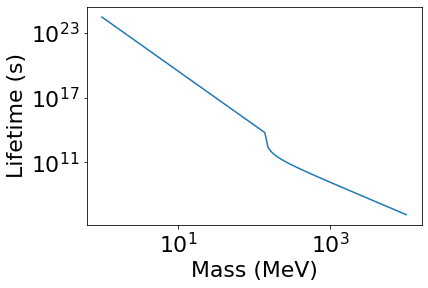

In [37]:
m_domain = np.logspace(0, 4, 100)
theta = 10**-10
lifetimes = [ec.lifetime(m, theta) for m in m_domain]
plt.loglog(m_domain, lifetimes)
plt.ylabel("Lifetime (s)")
plt.xlabel("Mass (MeV)")
plt.show()

## Check the lepton potential pre-factors

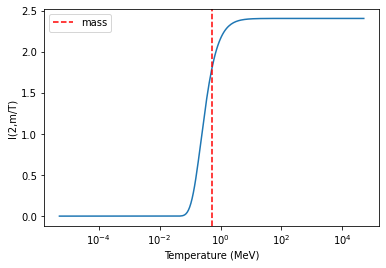

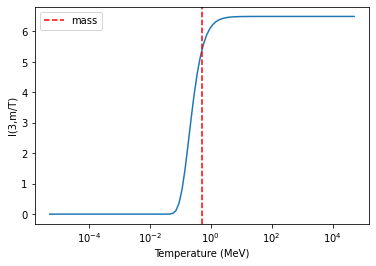

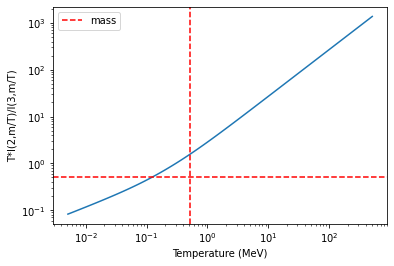

In [11]:
factors = []
T_domain = m_e*np.logspace(-5, 5, 251)
for T in T_domain:
    factors.append(ec.lepton_integral_interp(2, m_e/T))
plt.semilogx(T_domain, factors)
plt.ylabel("I(2,m/T)")
plt.xlabel("Temperature (MeV)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.legend()
plt.show()


factors = []
T_domain = m_e*np.logspace(-5, 5, 100)
for T in T_domain:
    factors.append(ec.lepton_integral_interp(3, m_e/T))
plt.figure()
plt.semilogx(T_domain, factors)
plt.ylabel("I(3,m/T)")
plt.xlabel("Temperature (MeV)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.legend()
plt.show()

factors = []
plt.figure()

# The average energy should converge to the mass: but it doesn't
# because the integral results just get too small. 
T_domain = m_e*np.logspace(-2, 3, 100)
for T in T_domain:
    factors.append(T*ec.lepton_integral_interp(3, m_e/T)/ec.lepton_integral_interp(2, m_e/T))
plt.loglog(T_domain, factors)

plt.xlabel("Temperature (MeV)")
plt.ylabel("T*I(2,m/T)/I(3,m/T)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.axhline(m_e, ls='--', c='r')
plt.legend()
plt.show()

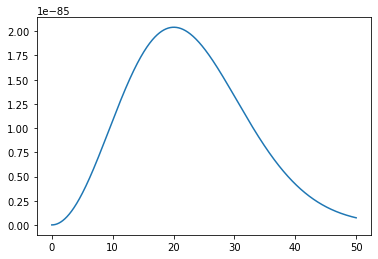

In [36]:
n=2
x=200
y_dom = np.linspace(0.001,50, 1000)
plt.plot(y_dom, y_dom**n/(np.exp(np.sqrt(x**2 + y_dom**2))-1))

# Old

In [36]:
m5_log_min, m5_log_max = 0, 5
m5_domain = np.logspace(m5_log_min, m5_log_max, 50)
theta_log_min, theta_log_max = -10, 0
theta_domain = np.logspace(theta_log_max, theta_log_min, 50)
tau_bbn = 10 #seconds: from Vincent's paper
sid_results = {
"thermalized": [],
"T_freezeout": [],
"T_thermal": [],
"not_boltzmann_supressed":[],
"decay_before_BBN":[],
"m4_required":[],
"lifetime":[]
}

start = time.time()
for theta in theta_domain:
    for key in sid_results:
        sid_results[key].append([])
    for m5 in m5_domain:
        thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**5, 1, theta, m5, 'electron', antineutrino=False, num_T=1000)
        sid_results['thermalized'][-1].append(thermalized)
        sid_results['T_freezeout'][-1].append(T_freezeout)
        sid_results['T_thermal'].append(T_thermal)
        if thermalized:
            sid_results['not_boltzmann_supressed'][-1].append(T_freezeout>m5)
        else:
            sid_results['not_boltzmann_supressed'][-1].append(True) #Not boltzmann supressed if it never thermalizes
        sid_results['decay_before_BBN'][-1].append(ec.lifetime(m5, theta)<tau_bbn)
        sid_results['m4_required'][-1].append(ec.m4_dark_matter(m5, ec.lifetime(m5, theta), 1, 1)) #relativistic DOFs don't matter, since Tf4=Tf5
        sid_results['lifetime'][-1].append(ec.lifetime(m5, theta)) 
        
print(time.time()-start)

253.042724609375


## Conditions that must be met

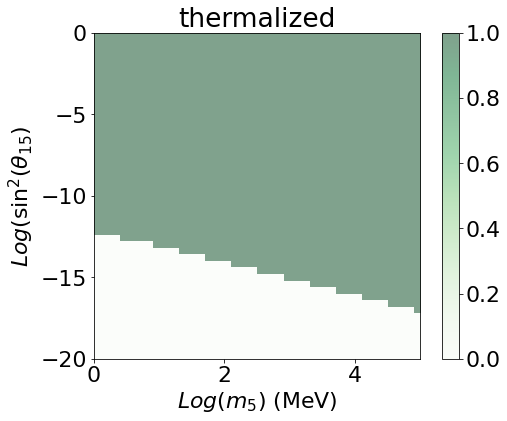

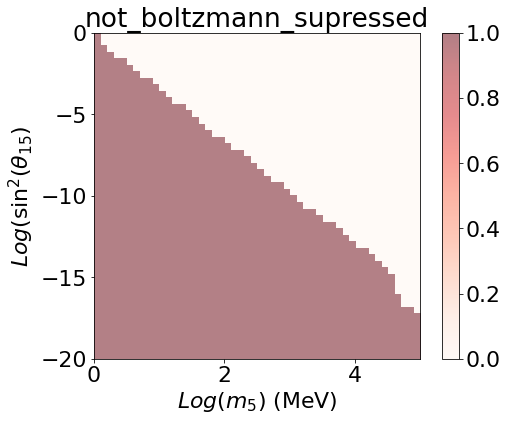

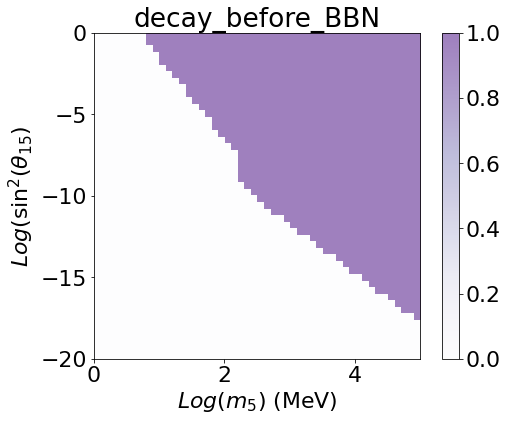

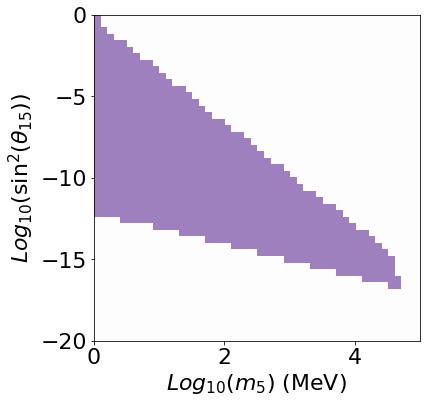

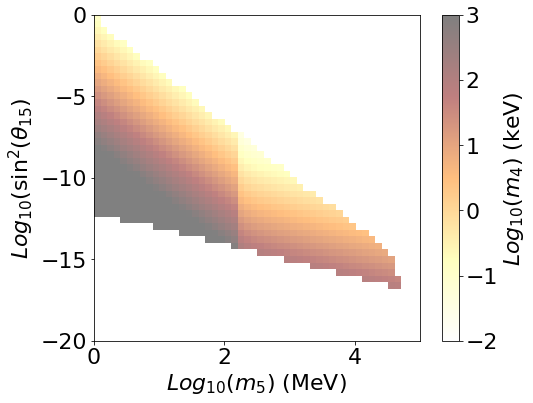

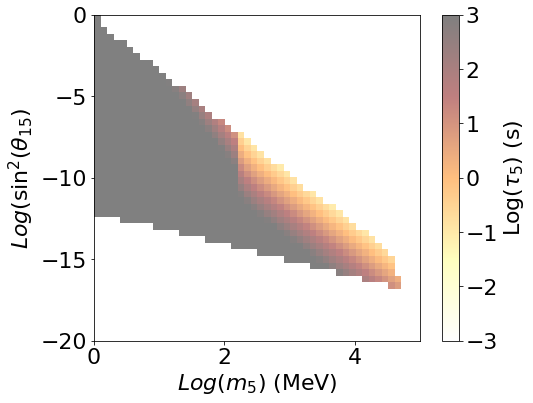

In [37]:
import matplotlib.pyplot as plt
import numpy as np

aspect = (m5_log_max- m5_log_min)/(2*theta_log_max- 2*theta_log_min)
keys = ['thermalized', 'not_boltzmann_supressed', 'decay_before_BBN']
colors = ['Greens', 'Reds', 'Purples']

for key, color in zip(keys, colors):
    plt.figure(figsize=(8,6))
    plt.imshow(sid_results[key], aspect=aspect, cmap=color, vmin=0, vmax=1, alpha=0.5, 
               extent=[m5_log_min, m5_log_max, 2*theta_log_min, 2*theta_log_max])
    # Add a colorbar to the plot
    plt.colorbar()
    plt.xlabel(r"$Log(m_5)$ (MeV)")
    plt.ylabel(r"$Log(\sin^2(\theta_{15})$")
    plt.title(key)
    plt.show()
    

plt.figure(figsize=(8,6))
combined = np.array(sid_results['not_boltzmann_supressed']) & np.array(sid_results['thermalized'])
plt.imshow(combined, aspect=aspect, cmap='Purples', alpha=0.5, vmin=0.1, vmax=1,
           extent=[m5_log_min, m5_log_max, 2*theta_log_min, 2*theta_log_max])
plt.xlabel(r"$Log_{10}(m_5)$ (MeV)")
plt.ylabel(r"$Log_{10}(\sin^2(\theta_{15}))$")
#plt.title("Thermalized and not boltzmann supressed")
plt.show()
    
plt.figure(figsize=(8,6))
combined = np.array(sid_results['not_boltzmann_supressed']) & np.array(sid_results['thermalized'])
m4s = combined*sid_results['m4_required']*10**3 #in keV
plt.imshow(np.log10(m4s+10**-5), aspect=aspect, cmap='afmhot_r', alpha=0.5, vmin=-2, vmax=3,
           extent=[m5_log_min, m5_log_max, 2*theta_log_min, 2*theta_log_max])
plt.xlabel(r"$Log_{10}(m_5)$ (MeV)")
plt.ylabel(r"$Log_{10}(\sin^2(\theta_{15})$")
#plt.title("Combined m_4")
plt.colorbar(label=r"$Log_{10}(m_4)$ (keV)")
plt.show()

plt.figure(figsize=(8,6))
combined = np.array(sid_results['not_boltzmann_supressed']) & np.array(sid_results['thermalized'])
lifetimes = combined*sid_results['lifetime'] #in keV
plt.imshow(np.log10(lifetimes+10**-10), aspect=aspect, cmap='afmhot_r', alpha=0.5, vmin=-3, vmax=3,
           extent=[m5_log_min, m5_log_max, 2*theta_log_min, 2*theta_log_max])
plt.xlabel(r"$Log(m_5)$ (MeV)")
plt.ylabel(r"$Log(\sin^2(\theta_{15})$")
#plt.title("Upper bound on lifetime")
plt.colorbar(label=r"Log($\tau_5$) (s)")
plt.show()

## Parameter scan across lifetimes and masses

In [31]:
m5_log_min, m5_log_max = np.log10(500), 4
m5_domain = np.logspace(m5_log_min, m5_log_max, 100)
lifetime_min, lifetime_max = -10, 0
lifetime_domain = np.logspace(lifetime_max, lifetime_min, 100)
dm_results = {
"m4_required":[]
}

start = time.time()
for lifetime in lifetime_domain:
    for key in dm_results:
        dm_results[key].append([])
    for m5 in m5_domain:
        dm_results['m4_required'][-1].append(ec.m4_dark_matter(m5, lifetime, 1, 1)) #relativistic DOFs don't matter, since Tf4=Tf5
        
print(time.time()-start)

0.023116111755371094


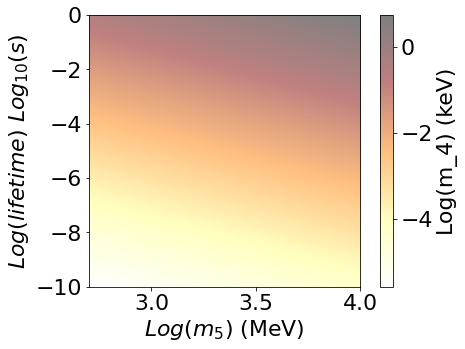

In [32]:
import matplotlib.pyplot as plt
import numpy as np

aspect = (m5_log_max-m5_log_min)/(lifetime_max-lifetime_min)
        
plt.figure(figsize=(8,6))
m4s = np.array(dm_results['m4_required'])*10**3
plt.imshow(np.log10(m4s), aspect=aspect, cmap='afmhot_r', alpha=0.5,
           extent=[m5_log_min, m5_log_max, lifetime_min, lifetime_max])
plt.xlabel(r"$Log(m_5)$ (MeV)")
plt.ylabel(r"$Log(lifetime)$ $Log_{10}(s)$")
plt.colorbar(label="Log(m_4) (keV)")
plt.show()

Sterile Garrazio benchmark

                & 1.47836 & 1.01618 & 1.01470 & 1.01465 & 1.01038 & 4.05590\\


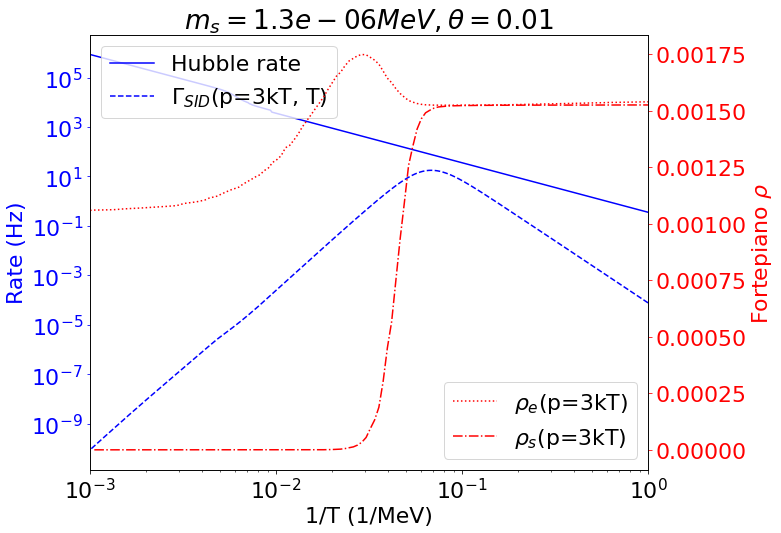

In [38]:
from python.fortepianoOutput import FortEPiaNORun

# Model parameters
params={
"m4": 1.3*10**-6, #MeV
"theta": 0.01
}

# Analytic results
T = np.logspace(0, 3, 400)
sid = ec.SID_rate(ec.avg_p(T), T, params["theta"], params["m4"], 'electron')

#thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**3, 1, params["theta"], params["m4"], 'electron', antineutrino=False, num_T=1000)

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate', c='b')
ax1.loglog(1/T, sid*MeVtoHz, label=r"$\Gamma_{SID}$(p=3kT, T)", c='b', ls='--')
#ax1.axvline(1/Tmax(params["m4"]), c='r', ls='--', label="Production peak")
# if thermalized:
#     ax1.axvline(1/T_thermal, c='r', ls='--', label=r"$\Gamma_{SID} = H$")
ax1.set_ylabel("Rate (Hz)")
ax1.set_xlabel("1/T (1/MeV)")
ax1.legend(loc=2)
ax1.yaxis.label.set_color('b')
ax1.tick_params(axis='y', colors='b')

# Fortepiano results
yref =7 # p=2.86kT according to fd.dat
fp_run = FortEPiaNORun("output/sterile_Garrazio_benchmark/", nnu=4, deltas=False,plots=False)
flavs = ['e', 'mu', 'tau', 's1']
labels = [r"$\rho_e$(p=3kT)", r"$\rho_\mu$(p=3kT)", r"$\rho_\tau$(p=3kT)", r"$\rho_s$(p=3kT)"]
lines = ["dotted", "dotted", "dotted", "dashdot"]
for i, flav, label, ls in zip(range(4), flavs, labels, lines):
    if flav not in ['mu', 'tau']:
        x, rho_ij = FortEPiaNORun.interpolateRhoIJ(fp_run, i, i, yref, mass=False)
        rho_ij = [r for _, r in sorted(zip(x, rho_ij))]
        x = sorted(x)
        ax2.semilogx(x, rho_ij, c='r', ls=ls, label=label)
ax2.set_ylabel(r"Fortepiano $\rho$")            
ax2.legend(loc=4)
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r')
plt.xlim(10**-3, 1)
plt.title(r"$m_s={} MeV, \theta={}$".format(params['m4'], params['theta']))
plt.show()

Sterile Garrazio benchmark e3

                & 1.50137 & 1.01721 & 1.01656 & 1.01654 & 0.57268 & 3.62298\\


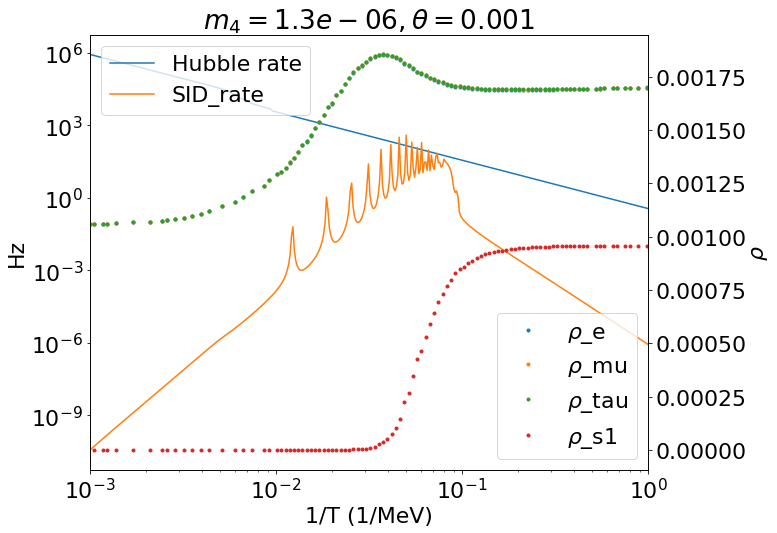

In [36]:
# Model parameters
# Model parameters
params={
"m4": 1.3*10**-6, #MeV
"theta": 0.001,
}

# Analytic results
T = np.logspace(0, 3, 400)
sid = ec.SID_rate_integrated(T, params["theta"], params["m4"], 'electron')

#thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**3, 1, params["theta"], params["m4"], 'electron', antineutrino=False, num_T=1000)

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate')
ax1.loglog(1/T, sid*MeVtoHz, label="SID_rate")
#ax1.axvline(1/Tmax(params["m4"]), c='r', ls='--', label="Production peak")
# if thermalized:
#     ax1.axvline(1/T_thermal, c='r', ls='--', label=r"$\Gamma_{SID} = H$")
ax1.set_ylabel("Hz")
ax1.set_xlabel("1/T (1/MeV)")
ax1.legend(loc=2)

# Fortepiano results
yref = 7 # p=2.86kT according to fd.dat
fp_run = FortEPiaNORun("output/sterile_Garrazio_benchmark_e3/", nnu=4, deltas=False,plots=False)
flavs = ['e', 'mu', 'tau', 's1']
for i, flav in zip(range(4), flavs):
    if i == 4:
        rho_ij = np.zeros(len(x))
    else:
        x, rho_ij = FortEPiaNORun.interpolateRhoIJ(fp_run, i, i, yref, mass=False)
    ax2.semilogx(x, rho_ij, '.', label=r"$\rho$_{}".format(flav))
ax2.set_ylabel(r"$\rho$")            
ax2.legend(loc=4)
plt.xlim(10**-3, 1)
plt.title(r"$m_4={}, \theta={}$".format(params['m4'], params['theta']))
plt.show()